In [4]:
!pip install PyWavelets

In [5]:
import cv2
import numpy as np
import pywt
from skimage import metrics
import matplotlib.pyplot as plt

# Load noisy image
image = cv2.imread('/content/Screenshot 2024-12-18 162628.png', cv2.IMREAD_COLOR)

# 1. Median Filter Denoising
median_denoised = cv2.medianBlur(image, 5)

# 2. Wavelet Denoising
def wavelet_denoising(img):
    coeffs = pywt.wavedec2(img.astype(np.float32), 'haar', level=2)
    coeffs_thresholded = [coeffs[0]]
    for detail_level in coeffs[1:]:
        thresholded = tuple(pywt.threshold(c, 0.1, mode='soft') for c in detail_level)
        coeffs_thresholded.append(thresholded)

    denoised = pywt.waverec2(coeffs_thresholded, 'haar')
    denoised = np.clip(denoised, 0, 255).astype(np.uint8)
    denoised = cv2.resize(denoised, (img.shape[1], img.shape[0]))
    return denoised

# 3. Noise2Void placeholder
def noise2void_denoising(img):
    return img  # Replace with actual denoised output from Noise2Void model

# Denoise
wavelet_denoised = wavelet_denoising(image)
noise2void_denoised = noise2void_denoising(image)

# Convert to RGB for visualization and metrics
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
median_rgb = cv2.cvtColor(median_denoised, cv2.COLOR_BGR2RGB)
wavelet_rgb = cv2.cvtColor(wavelet_denoised, cv2.COLOR_BGR2RGB)
noise2void_rgb = cv2.cvtColor(noise2void_denoised, cv2.COLOR_BGR2RGB)

# Metric Calculation
def calculate_metrics(original, denoised):
    psnr = metrics.peak_signal_noise_ratio(original, denoised)
    ssim = metrics.structural_similarity(original, denoised, channel_axis=-1, win_size=5)
    mse = metrics.mean_squared_error(original, denoised)
    return psnr, ssim, mse

# Metrics
psnr_median, ssim_median, mse_median = calculate_metrics(image_rgb, median_rgb)
psnr_wavelet, ssim_wavelet, mse_wavelet = calculate_metrics(image_rgb, wavelet_rgb)
psnr_noise2void, ssim_noise2void, mse_noise2void = calculate_metrics(image_rgb, noise2void_rgb)

# Print metrics
print(f"Median Filter     - PSNR: {psnr_median:.2f}, SSIM: {ssim_median:.4f}, MSE: {mse_median:.2f}")
print(f"Wavelet Denoising - PSNR: {psnr_wavelet:.2f}, SSIM: {ssim_wavelet:.4f}, MSE: {mse_wavelet:.2f}")
print(f"Noise2Void        - PSNR: {psnr_noise2void:.2f}, SSIM: {ssim_noise2void:.4f}, MSE: {mse_noise2void:.2f}")



/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Median Filter     - PSNR: 21.68, SSIM: 0.7663, MSE: 441.26
Wavelet Denoising - PSNR: 27.04, SSIM: 0.9367, MSE: 128.60
Noise2Void        - PSNR: inf, SSIM: 1.0000, MSE: 0.00


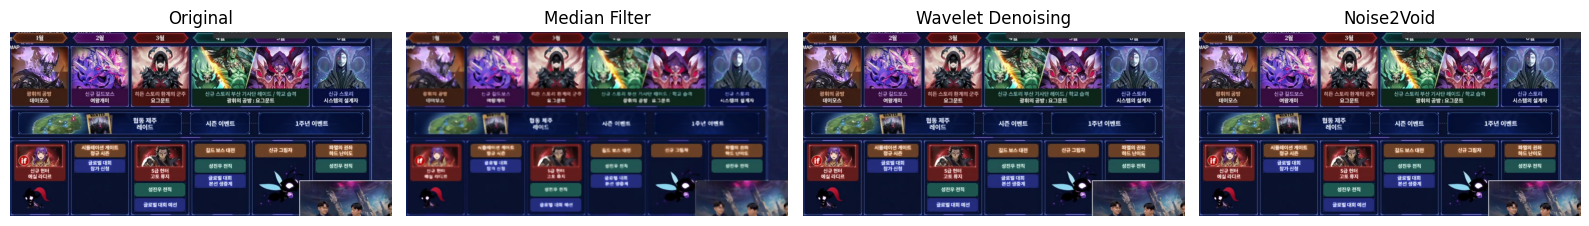

In [6]:
import matplotlib.pyplot as plt

# Display the images
titles = ['Original', 'Median Filter', 'Wavelet Denoising', 'Noise2Void']
images = [image_rgb, median_rgb, wavelet_rgb, noise2void_rgb]

plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Please upload a video file (preferably .mp4)


Saving 1472492_People_3840x2160.mp4 to 1472492_People_3840x2160.mp4
Video uploaded: 1472492_People_3840x2160.mp4
Video properties:
- Total frames: 317
- FPS: 25.00
- Duration: 12.68 seconds


Extracting frames: 100%|██████████| 317/317 [00:13<00:00, 22.96it/s]


Extracted 64 frames to /content/video_frames


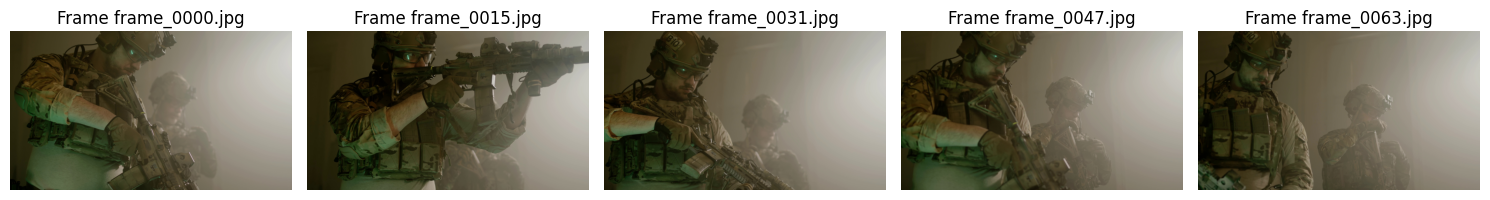

In [7]:
# Import necessary libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files

# Create a directory to store the extracted frames
output_dir = '/content/video_frames'
os.makedirs(output_dir, exist_ok=True)

# Upload a video file (for Google Colab)
print("Please upload a video file (preferably .mp4)")
uploaded = files.upload()
video_filename = list(uploaded.keys())[0]
print(f"Video uploaded: {video_filename}")

# Alternative: If you want to use a sample video for testing
# Uncomment this section if you don't want to upload a video
"""
# Download a sample video if needed
!wget -q -O sample_video.mp4 https://github.com/opencv/opencv_extra/raw/master/testdata/highgui/video/big_buck_bunny.mp4
video_filename = "sample_video.mp4"
"""

def extract_frames(video_path, output_folder, frame_interval=1):
    """
    Extract frames from a video and save them as JPEG files

    Parameters:
    video_path (str): Path to the video file
    output_folder (str): Folder to save extracted frames
    frame_interval (int): Extract every nth frame
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get video properties
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps

    print(f"Video properties:")
    print(f"- Total frames: {frame_count}")
    print(f"- FPS: {fps:.2f}")
    print(f"- Duration: {duration:.2f} seconds")

    # Initialize frame counter
    count = 0
    saved_count = 0

    # Loop through the video frames
    for _ in tqdm(range(frame_count), desc="Extracting frames"):
        # Read the next frame
        ret, frame = cap.read()

        # If frame is read correctly ret is True
        if not ret:
            break

        # Save frame if it's at the specified interval
        if count % frame_interval == 0:
            # Create the output filename
            frame_filename = f"frame_{saved_count:04d}.jpg"
            frame_path = os.path.join(output_folder, frame_filename)

            # Save the frame as JPEG file
            cv2.imwrite(frame_path, frame)
            saved_count += 1

        count += 1

    # Release the video capture object
    cap.release()

    print(f"Extracted {saved_count} frames to {output_folder}")
    return saved_count

# Extract frames from the uploaded video (every 5th frame)
num_frames = extract_frames(video_filename, output_dir, frame_interval=5)

# Display some of the extracted frames
def display_extracted_frames(frames_dir, num_to_display=5):
    """Display a sample of extracted frames"""
    # Get all frame files
    frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])

    # Limit the number to display
    num_to_display = min(num_to_display, len(frame_files))

    if num_to_display == 0:
        print("No frames to display!")
        return

    # Select frames evenly distributed among all extracted frames
    indices = np.linspace(0, len(frame_files)-1, num_to_display, dtype=int)
    selected_frames = [frame_files[i] for i in indices]

    # Display the frames
    plt.figure(figsize=(15, 10))
    for i, frame_file in enumerate(selected_frames):
        img_path = os.path.join(frames_dir, frame_file)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

        plt.subplot(1, num_to_display, i+1)
        plt.imshow(img_rgb)
        plt.title(f"Frame {frame_file}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display a sample of the extracted frames
display_extracted_frames(output_dir, num_to_display=5)

Processing frames: 100%|██████████| 64/64 [00:18<00:00,  3.50it/s]


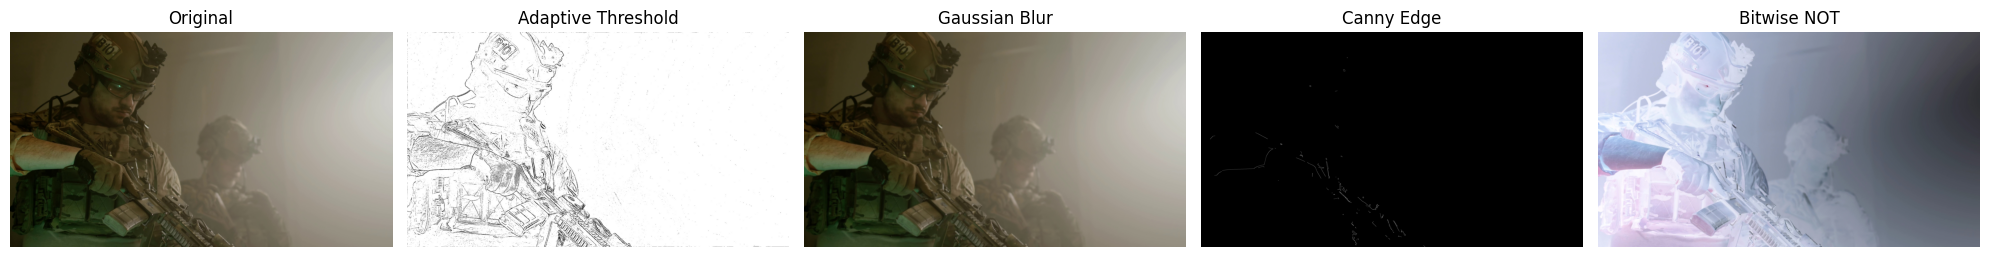

Creating original_video.mp4: 100%|██████████| 64/64 [00:06<00:00,  9.21it/s]


Video saved: /content/processed_videos/original_video.mp4


Creating adaptive_threshold_video.mp4: 100%|██████████| 64/64 [00:08<00:00,  7.56it/s]


Video saved: /content/processed_videos/adaptive_threshold_video.mp4


Creating gaussian_blur_video.mp4: 100%|██████████| 64/64 [00:05<00:00, 10.73it/s]


Video saved: /content/processed_videos/gaussian_blur_video.mp4


Creating canny_edge_video.mp4: 100%|██████████| 64/64 [00:04<00:00, 15.57it/s]


Video saved: /content/processed_videos/canny_edge_video.mp4


Creating bitwise_not_video.mp4: 100%|██████████| 64/64 [00:06<00:00,  9.78it/s]


Video saved: /content/processed_videos/bitwise_not_video.mp4
Collage saved: /content/collages/original_collage.jpg
Collage saved: /content/collages/adaptive_threshold_collage.jpg
Collage saved: /content/collages/gaussian_blur_collage.jpg
Collage saved: /content/collages/canny_edge_collage.jpg
Collage saved: /content/collages/bitwise_not_collage.jpg


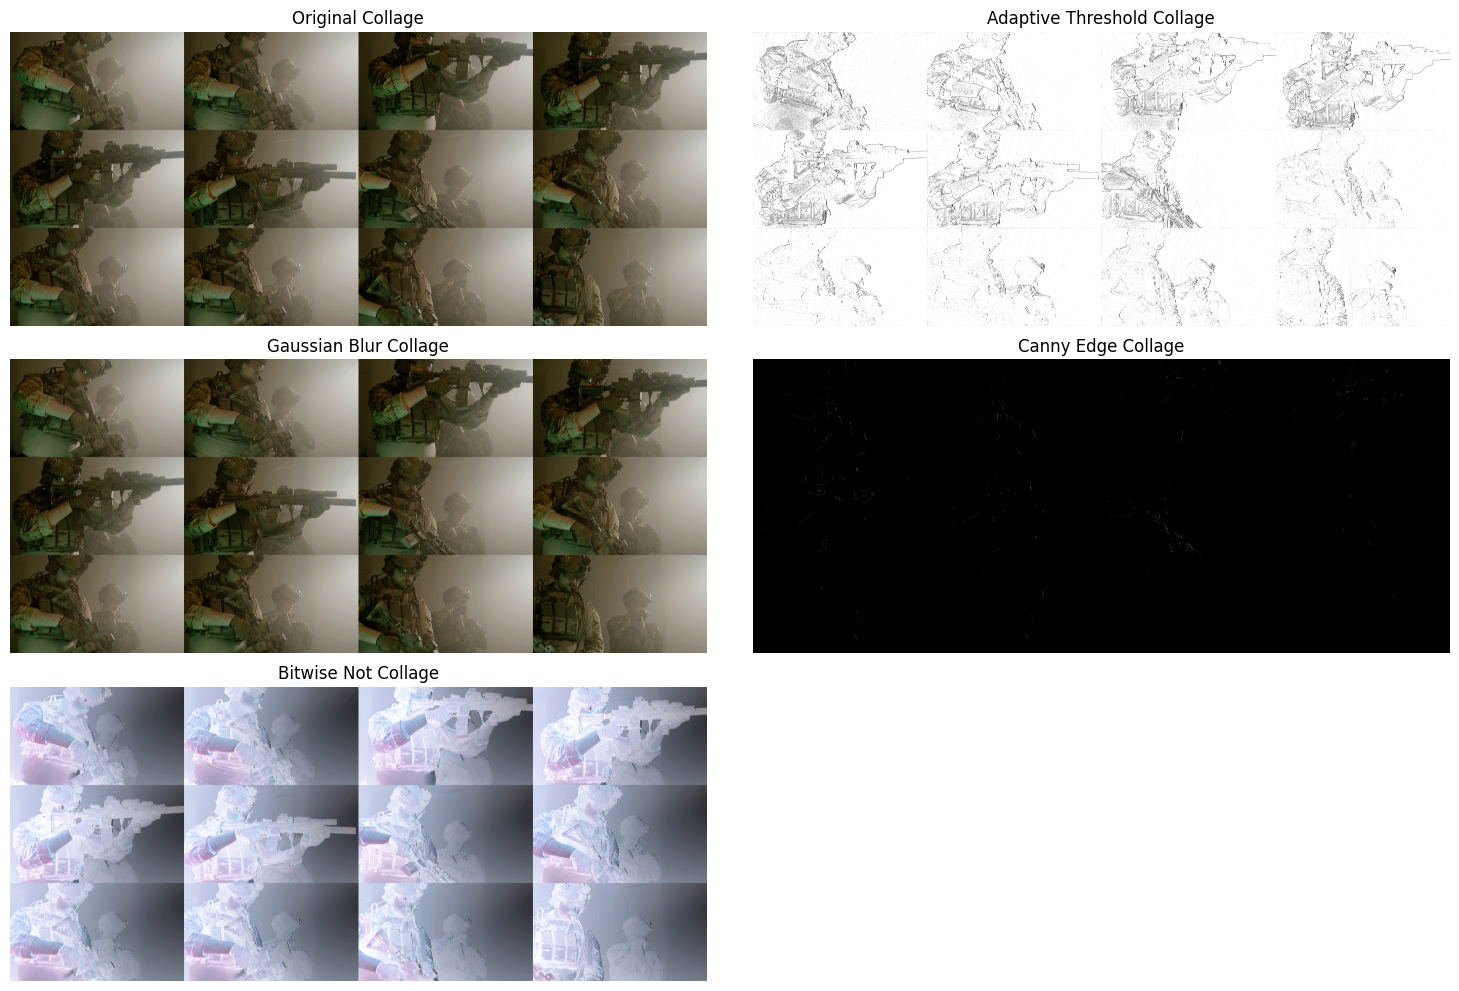


----- Summary of Created Files -----
1. Extracted frames: 64 frames in /content/video_frames

2. Processed frames:
   - Adaptive Threshold: 64 frames in /content/processed_frames/adaptive_thresh
   - Gaussian Blur: 64 frames in /content/processed_frames/gaussian_smooth
   - Canny Edge: 64 frames in /content/processed_frames/canny_edge
   - Bitwise Not: 64 frames in /content/processed_frames/bitwise_not

3. Created videos:
   - Original: /content/processed_videos/original_video.mp4
   - Adaptive Threshold: /content/processed_videos/adaptive_threshold_video.mp4
   - Gaussian Blur: /content/processed_videos/gaussian_blur_video.mp4
   - Canny Edge: /content/processed_videos/canny_edge_video.mp4
   - Bitwise Not: /content/processed_videos/bitwise_not_video.mp4

4. Created collages:
   - Original: /content/collages/original_collage.jpg
   - Adaptive Threshold: /content/collages/adaptive_threshold_collage.jpg
   - Gaussian Blur: /content/collages/gaussian_blur_collage.jpg
   - Canny Edge: /c

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create directories for processed frames
processed_dir = '/content/processed_frames'
os.makedirs(processed_dir, exist_ok=True)

# Create subdirectories for each processing technique
adaptive_thresh_dir = os.path.join(processed_dir, 'adaptive_thresh')
gaussian_smooth_dir = os.path.join(processed_dir, 'gaussian_smooth')
canny_edge_dir = os.path.join(processed_dir, 'canny_edge')
bitwise_not_dir = os.path.join(processed_dir, 'bitwise_not')

# Create directories if they don't exist
for dir_path in [adaptive_thresh_dir, gaussian_smooth_dir, canny_edge_dir, bitwise_not_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Source directory with extracted frames
frames_dir = '/content/video_frames'

# Process all frames with different techniques
def process_frames(input_dir):
    """Apply different image processing techniques to all frames"""
    # Get all frame files
    frame_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.jpg')])

    for frame_file in tqdm(frame_files, desc="Processing frames"):
        # Read the frame
        img_path = os.path.join(input_dir, frame_file)
        frame = cv2.imread(img_path)

        if frame is None:
            print(f"Warning: Could not read {img_path}")
            continue

        # Convert to grayscale for some operations
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 1. Adaptive Thresholding
        adaptive_thresh = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        # Convert back to BGR for video creation consistency
        adaptive_thresh_bgr = cv2.cvtColor(adaptive_thresh, cv2.COLOR_GRAY2BGR)
        cv2.imwrite(os.path.join(adaptive_thresh_dir, frame_file), adaptive_thresh_bgr)

        # 2. Gaussian Smoothing
        gaussian_blur = cv2.GaussianBlur(frame, (15, 15), 0)
        cv2.imwrite(os.path.join(gaussian_smooth_dir, frame_file), gaussian_blur)

        # 3. Canny Edge Detection
        edges = cv2.Canny(gray, 100, 200)
        # Convert back to BGR for video creation consistency
        edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        cv2.imwrite(os.path.join(canny_edge_dir, frame_file), edges_bgr)

        # 4. Bitwise NOT
        bitwise_not = cv2.bitwise_not(frame)
        cv2.imwrite(os.path.join(bitwise_not_dir, frame_file), bitwise_not)

# Process all frames
process_frames(frames_dir)

# Display sample results from each processing technique
def display_processing_results():
    """Display sample results from each processing technique"""
    # Get a sample frame from the middle of the sequence
    frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])
    if not frame_files:
        print("No frames to display!")
        return

    # Choose a frame from the middle
    sample_frame = frame_files[len(frame_files) // 2]

    original = cv2.imread(os.path.join(frames_dir, sample_frame))
    adaptive = cv2.imread(os.path.join(adaptive_thresh_dir, sample_frame))
    gaussian = cv2.imread(os.path.join(gaussian_smooth_dir, sample_frame))
    canny = cv2.imread(os.path.join(canny_edge_dir, sample_frame))
    bitwise = cv2.imread(os.path.join(bitwise_not_dir, sample_frame))

    # Convert BGR to RGB for display
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    adaptive = cv2.cvtColor(adaptive, cv2.COLOR_BGR2RGB)
    gaussian = cv2.cvtColor(gaussian, cv2.COLOR_BGR2RGB)
    canny = cv2.cvtColor(canny, cv2.COLOR_BGR2RGB)
    bitwise = cv2.cvtColor(bitwise, cv2.COLOR_BGR2RGB)

    # Display the frames
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 5, 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(adaptive)
    plt.title("Adaptive Threshold")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(gaussian)
    plt.title("Gaussian Blur")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(canny)
    plt.title("Canny Edge")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(bitwise)
    plt.title("Bitwise NOT")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display processing results
display_processing_results()

# Create videos from processed frames
def create_video_from_frames(frames_dir, output_video_path, fps=30):
    """Create a video from frames in a directory"""
    # Get all frame files
    frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])

    if not frame_files:
        print(f"No frames found in {frames_dir}")
        return

    # Read the first frame to get dimensions
    first_frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
    height, width, layers = first_frame.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # mp4 format
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Add frames to the video
    for frame_file in tqdm(frame_files, desc=f"Creating {os.path.basename(output_video_path)}"):
        frame_path = os.path.join(frames_dir, frame_file)
        frame = cv2.imread(frame_path)
        if frame is not None:
            out.write(frame)

    # Release the video writer
    out.release()
    print(f"Video saved: {output_video_path}")

# Create output directory for videos
videos_dir = '/content/processed_videos'
os.makedirs(videos_dir, exist_ok=True)

# Create videos from each set of processed frames
processing_techniques = {
    'original': frames_dir,
    'adaptive_threshold': adaptive_thresh_dir,
    'gaussian_blur': gaussian_smooth_dir,
    'canny_edge': canny_edge_dir,
    'bitwise_not': bitwise_not_dir
}

for name, dir_path in processing_techniques.items():
    output_video = os.path.join(videos_dir, f"{name}_video.mp4")
    create_video_from_frames(dir_path, output_video, fps=24)

# Create a collage from video frames
def create_frame_collage(frames_dir, output_path, grid_size=(3, 4)):
    """Create a collage from video frames"""
    # Get all frame files
    frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])

    if not frame_files:
        print(f"No frames found in {frames_dir}")
        return

    # Determine how many frames to use
    rows, cols = grid_size
    num_frames_needed = rows * cols

    # Select frames evenly throughout the sequence
    if len(frame_files) <= num_frames_needed:
        selected_frames = frame_files
    else:
        indices = np.linspace(0, len(frame_files) - 1, num_frames_needed, dtype=int)
        selected_frames = [frame_files[i] for i in indices]

    # Read the first frame to get dimensions
    first_frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
    frame_height, frame_width, _ = first_frame.shape

    # Create a blank canvas
    collage_width = frame_width * cols
    collage_height = frame_height * rows
    collage = np.zeros((collage_height, collage_width, 3), dtype=np.uint8)

    # Place frames in the collage
    for idx, frame_file in enumerate(selected_frames):
        if idx >= num_frames_needed:
            break

        # Calculate position in grid
        row = idx // cols
        col = idx % cols

        # Read the frame
        frame = cv2.imread(os.path.join(frames_dir, frame_file))

        if frame is None:
            continue

        # Calculate position in collage
        y_start = row * frame_height
        y_end = (row + 1) * frame_height
        x_start = col * frame_width
        x_end = (col + 1) * frame_width

        # Place the frame in the collage
        collage[y_start:y_end, x_start:x_end] = frame

    # Save the collage
    cv2.imwrite(output_path, collage)
    print(f"Collage saved: {output_path}")

    # Return the collage for display
    return cv2.cvtColor(collage, cv2.COLOR_BGR2RGB)

# Create directory for collages
collages_dir = '/content/collages'
os.makedirs(collages_dir, exist_ok=True)

# Create collages for original and processed frames
collages = {}
for name, dir_path in processing_techniques.items():
    output_path = os.path.join(collages_dir, f"{name}_collage.jpg")
    collages[name] = create_frame_collage(dir_path, output_path)

# Display the collages
def display_collages():
    """Display all created collages"""
    plt.figure(figsize=(15, 10))

    # Calculate grid size based on number of collages
    num_collages = len(collages)
    rows = (num_collages + 1) // 2  # Round up division

    for i, (name, collage) in enumerate(collages.items()):
        plt.subplot(rows, 2, i + 1)
        plt.imshow(collage)
        plt.title(f"{name.replace('_', ' ').title()} Collage")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display all collages
display_collages()

# Print summary of created files
print("\n----- Summary of Created Files -----")
print(f"1. Extracted frames: {len(os.listdir(frames_dir))} frames in {frames_dir}")

print("\n2. Processed frames:")
for name, dir_path in processing_techniques.items():
    if name != 'original':
        print(f"   - {name.replace('_', ' ').title()}: {len(os.listdir(dir_path))} frames in {dir_path}")

print("\n3. Created videos:")
for name in processing_techniques.keys():
    print(f"   - {name.replace('_', ' ').title()}: {videos_dir}/{name}_video.mp4")

print("\n4. Created collages:")
for name in processing_techniques.keys():
    print(f"   - {name.replace('_', ' ').title()}: {collages_dir}/{name}_collage.jpg")

In [9]:
from google.colab import files
files.upload()  # Upload kaggle.json

# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle (1).json to kaggle (1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pevogam/ucf101")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ucf101


In [11]:
import os

# Check the folder structure under UCF101
dataset_path = '/kaggle/input/ucf101/UCF101'
for root, dirs, files in os.walk(dataset_path):
    print("📁", root)
    for d in dirs:
        print(" ┣━", d)
    for f in files[:5]:  # Show only first 5 files to avoid overload
        print(" ┗━", f)
    break  # Only show top-level content for now


📁 /kaggle/input/ucf101/UCF101
 ┣━ UCF-101


In [12]:
import kagglehub
import os, shutil, random

# Download dataset
path = kagglehub.dataset_download("pevogam/ucf101")
print("Path to dataset files:", path)

# ✅ Corrected source path based on your folder structure
SOURCE_DIR = os.path.join(path, 'UCF101', 'UCF-101')  # Corrected path
DEST_DIR = './UCF101_subset'
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

os.makedirs(DEST_DIR, exist_ok=True)

for cls in SELECTED_CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    dest_class_path = os.path.join(DEST_DIR, cls)
    os.makedirs(dest_class_path, exist_ok=True)

    selected = random.sample(os.listdir(class_path), VIDEOS_PER_CLASS)
    for video in selected:
        shutil.copy(os.path.join(class_path, video), dest_class_path)


Path to dataset files: /kaggle/input/ucf101


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import seaborn as sns

# Define paths and parameters
DATA_DIR = './UCF101_subset'
FRAME_SIZE = (112, 112)  # Width, Height
SEQUENCE_LENGTH = 16  # Number of frames to use per video
FRAME_SKIP = 5  # Extract every 5th frame

def extract_frames(video_path, frame_size, sequence_length, frame_skip):
    """Extract frames from a video and return as a numpy array."""
    frames = []
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    success = True

    while success:
        success, frame = cap.read()
        if not success:
            break

        if frame_count % frame_skip == 0:
            # Convert from BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Resize frame
            frame = cv2.resize(frame, frame_size)
            frames.append(frame)

            if len(frames) == sequence_length:
                break

        frame_count += 1

    cap.release()

    # If we don't have enough frames, pad with zeros
    if len(frames) < sequence_length:
        frames.extend([np.zeros((frame_size[1], frame_size[0], 3), dtype=np.uint8)] * (sequence_length - len(frames)))

    # Convert to numpy array and normalize
    frames = np.array(frames).astype(np.float32) / 255.0

    return frames

# Load and preprocess the dataset
X = []  # Will contain frame sequences
y = []  # Will contain class labels
class_names = []

import os
for class_name in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, class_name)
    class_names.append(class_name)

    for video_file in os.listdir(class_dir):
        video_path = os.path.join(class_dir, video_file)
        print(f"Processing {video_path}")

        # Extract frames from the video
        frames = extract_frames(video_path, FRAME_SIZE, SEQUENCE_LENGTH, FRAME_SKIP)

        X.append(frames)
        y.append(class_name)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print(f"Classes: {label_encoder.classes_}")

# Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Processing ./UCF101_subset/Typing/v_Typing_g10_c02.avi
Processing ./UCF101_subset/Typing/v_Typing_g18_c01.avi
Processing ./UCF101_subset/Typing/v_Typing_g09_c01.avi
Processing ./UCF101_subset/Typing/v_Typing_g11_c04.avi
Processing ./UCF101_subset/Typing/v_Typing_g04_c01.avi
Processing ./UCF101_subset/Typing/v_Typing_g05_c04.avi
Processing ./UCF101_subset/Typing/v_Typing_g17_c01.avi
Processing ./UCF101_subset/Typing/v_Typing_g07_c03.avi
Processing ./UCF101_subset/Typing/v_Typing_g06_c02.avi
Processing ./UCF101_subset/Typing/v_Typing_g08_c07.avi
Processing ./UCF101_subset/Basketball/v_Basketball_g06_c02.avi
Processing ./UCF101_subset/Basketball/v_Basketball_g02_c04.avi
Processing ./UCF101_subset/Basketball/v_Basketball_g18_c01.avi
Processing ./UCF101_subset/Basketball/v_Basketball_g18_c04.avi
Processing ./UCF101_subset/Basketball/v_Basketball_g11_c05.avi
Processing ./UCF101_subset/Basketball/v_Basketball_g11_c01.avi
Processing ./UCF101_subset/Basketball/v_Basketball_g01_c01.avi
Processin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 28, 28,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 16, 14, 14,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 16, 25088)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │    25,953,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,080,069 (99.49 MB)

 Trainable params: 26,080,069 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 705ms/step - accuracy: 0.1170 - loss: 2.1801 - val_accuracy: 0.2000 - val_loss: 1.6162
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.2156 - loss: 1.7221 - val_accuracy: 0.5000 - val_loss: 1.5314
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.3281 - loss: 1.5697 - val_accuracy: 0.5000 - val_loss: 1.4862
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.3524 - loss: 1.3958 - val_accuracy: 0.4000 - val_loss: 1.4418
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.5069 - loss: 1.1851 - val_accuracy: 0.5000 - val_loss: 1.3637
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.6736 - loss: 1.0600 - val_accuracy: 0.5000 - val_loss: 1.2315
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7288 - loss: 0.8747 - val_accuracy: 0.5000 - val_loss: 1.3170
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.7347 - loss: 0.7078 - val_accuracy: 0.5000 - val_loss

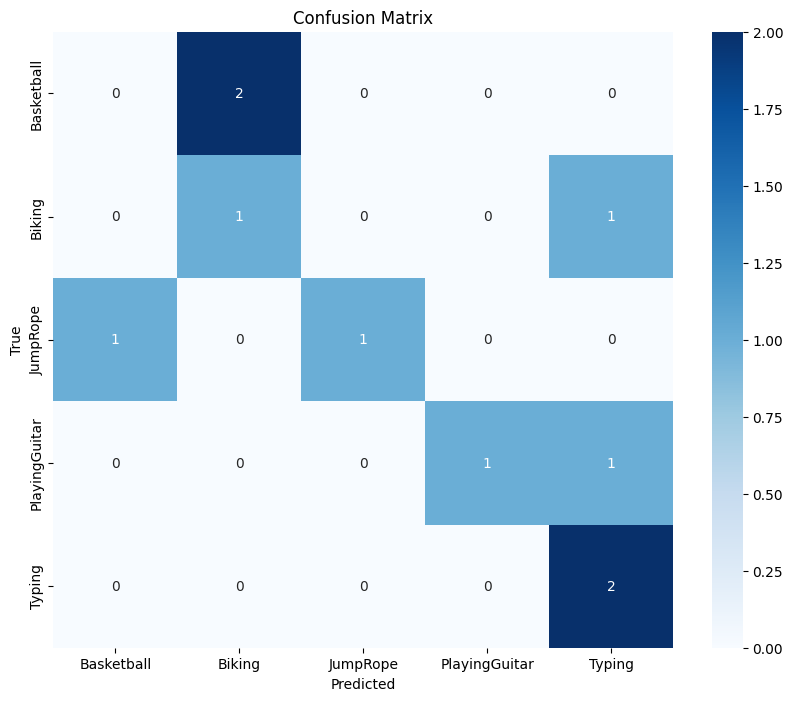


Classification Report:
               precision    recall  f1-score   support

   Basketball       0.00      0.00      0.00         2
       Biking       0.33      0.50      0.40         2
     JumpRope       1.00      0.50      0.67         2
PlayingGuitar       1.00      0.50      0.67         2
       Typing       0.50      1.00      0.67         2

     accuracy                           0.50        10
    macro avg       0.57      0.50      0.48        10
 weighted avg       0.57      0.50      0.48        10



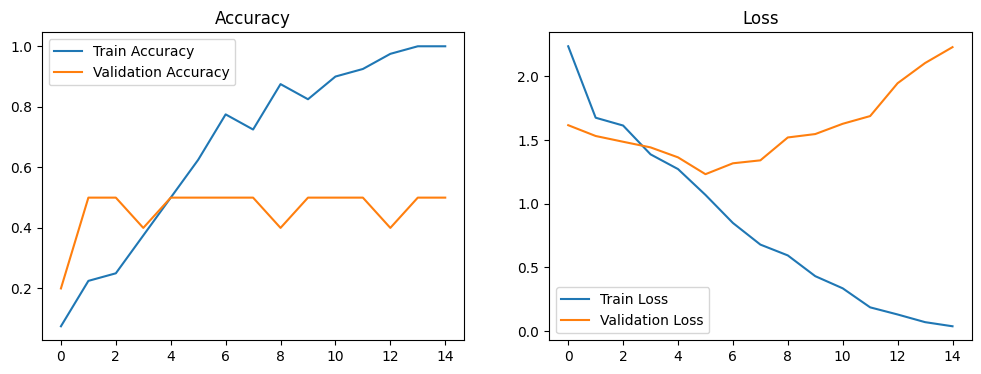


Per-class Metrics:
           Class  Precision  Recall  F1-Score
0     Basketball   0.000000     0.0  0.000000
1         Biking   0.333333     0.5  0.400000
2       JumpRope   1.000000     0.5  0.666667
3  PlayingGuitar   1.000000     0.5  0.666667
4         Typing   0.500000     1.0  0.666667


In [14]:
# CNN+LSTM Model
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        # TimeDistributed wrapper applies the same Conv2D layer to each frame
        TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        LSTM(256, return_sequences=False),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train the model
input_shape = (SEQUENCE_LENGTH, FRAME_SIZE[1], FRAME_SIZE[0], 3)  # (frames, height, width, channels)
num_classes = len(class_names)

model = build_cnn_lstm_model(input_shape, num_classes)
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=8
)

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
report = classification_report(y_true, y_pred,
                              target_names=label_encoder.classes_,
                              output_dict=True)
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Calculate precision, recall and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Create a dataframe to display metrics by class
import pandas as pd
metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})
print("\nPer-class Metrics:")
print(metrics_df)